### Calculate condition specificity, annotate cluster size

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import time
import sys
from joblib import Parallel, delayed
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from matplotlib.colors import ListedColormap
from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hypergeom, pearsonr
from scipy import stats
import random
import matplotlib as mpl

import matplotlib.cm as cm
import matplotlib.colors as mcolors 

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 150)
#sc.set_figure_params(figsize=(20, 4))
mpl.rcParams['font.family'] = 'NimbusSanL'

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
de_by_guide = pd.read_csv('../3_DE_analysis/results/DE_by_guide.correlation_results.csv', index_col=0)
donor_robustness_summary = pd.read_csv('../3_DE_analysis/results/DE_donor_robustness_correlation_summary.csv', index_col=0)

In [7]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad', backed='r')
adata_de_obs = adata_de.obs.copy()
corr_df_all = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv', index_col=0)
de_summary_stats = pd.read_csv('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
#adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad', backed='r')
downstream_gene_df = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering_downstream_genes.csv', index_col=0)
cluster_nde75_ntotal50 = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.csv', index_col=0)

### Calculate the correlation mean of rest, stim8hr, stim48hr, and across condition (shared) for each cluster

In [4]:
def corr_compute(df):
    X = df.values
    row_means = X.mean(axis=1, keepdims=True)
    row_stds = X.std(axis=1, keepdims=True)
    Z = (X - row_means) / row_stds
    R_unscaled = Z @ Z.T
    R = R_unscaled / (X.shape[1])
    corr_df = pd.DataFrame(R, index=df.index.tolist(), columns=df.index.tolist())
    return corr_df

def corr_mean_by_condition(df):
    df = df.reset_index()
    df = df.rename(columns={'index': 'Index_ID'})
    corr_all_long = pd.melt(df, 
                            id_vars=['Index_ID'],
                            var_name='Column_ID',
                            value_name='Correlation_Value'
                           )
    corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
    corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
    corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]
    
    corr_all_long['Canonical_Pair'] = corr_all_long.apply(
        lambda row: tuple(sorted([row['Index_ID'], row['Column_ID']])),
        axis=1
    )
    corr_all_long = corr_all_long.drop_duplicates(subset=['Canonical_Pair'], keep='first')
    corr_all_long = corr_all_long.drop(columns=['Canonical_Pair'])
    
    corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value
    corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value
    corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value

    corr_shared = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value
    
    return np.mean(corr_rest), np.mean(corr_stim8hr), np.mean(corr_stim48hr), np.mean(corr_shared)

In [5]:
cluster_df = pd.DataFrame(cluster_nde75_ntotal50[['target_contrast_corrected',
                                                  'hdbscan']].drop_duplicates()['hdbscan'].value_counts())
cluster_df.columns = ['cluster_gene_size']
cluster_df['corr_rest'] = 0
cluster_df['corr_stim8hr'] = 0
cluster_df['corr_stim48hr'] = 0
cluster_df['corr_shared'] = 0

In [8]:
for cl in cluster_df.index.unique():
    gene_id_list = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_corrected']
    obs_names = adata_de_obs[adata_de_obs['target_contrast_corrected'].isin(gene_id_list)].index
    corr_df = corr_df_all.loc[obs_names,obs_names].copy()

    cluster_df.loc[cl, ['corr_rest', 'corr_stim8hr', 'corr_stim48hr', 'corr_shared']] = corr_mean_by_condition(corr_df)

cluster_df['corr_max'] = cluster_df.iloc[:,1:4].max(1)
cluster_df['corr_std'] = cluster_df.iloc[:,1:4].std(1) 
cluster_df['corr_cov'] = cluster_df.iloc[:,1:4].std(1) / cluster_df.iloc[:,1:4].mean(1)
cluster_df['corr_min'] = cluster_df.iloc[:,1:4].min(1)
cluster_df['corr_mean'] = cluster_df.iloc[:,1:4].mean(1)
cluster_df.sort_index(axis=0, ascending=True, inplace=True)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_12526/2492319127.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03171675341206319' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cl, ['corr_rest', 'corr_stim8hr', 'corr_stim48hr', 'corr_shared']] = corr_mean_by_condition(corr_df)
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_12526/2492319127.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.026276039328289806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cl, ['corr_rest', 'corr_stim8hr', 'corr_stim48hr', 'corr_shared']] = corr_mean_by_condition(corr_df)
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_12526/2492319127.py:6: FutureWarning: Setting an item of incompati

### Classify clusters

In [8]:
corr_cov_thres = 0.5

In [9]:
cluster_df.loc[cluster_df.corr_cov<=corr_cov_thres,'condition_specificity'] = 'across_condition'

In [10]:
corr_fc_thres = 1.2
corr_thres = 0.2

def get_condition_specificity(row):
    # Calculate ratios
    r_rest = row['corr_rest'] / row['corr_mean']
    r_stim8hr = row['corr_stim8hr'] / row['corr_mean']
    r_stim48hr = row['corr_stim48hr'] / row['corr_mean']
    
    # Check pairs first (priority over singles)
    if ((r_rest>corr_fc_thres) or (row['corr_rest']>corr_thres)) and ((r_stim8hr>corr_fc_thres) or (row['corr_stim8hr']>corr_thres)):
        return 'Rest_Stim8hr'
    elif ((r_rest>corr_fc_thres) or (row['corr_rest']>corr_thres)) and ((r_stim48hr>corr_fc_thres) or (row['corr_stim48hr']>corr_thres)):
        return 'Rest_Stim48hr'
    elif ((r_stim8hr>corr_fc_thres) or (row['corr_stim8hr']>corr_thres)) and ((r_stim48hr>corr_fc_thres) or (row['corr_stim48hr']>corr_thres)):
        return 'Stim8hr_Stim48hr'
        
    # Check singles
    elif r_rest > corr_fc_thres:
        return 'Rest'
    elif r_stim8hr > corr_fc_thres:
        return 'Stim8hr'
    elif r_stim48hr > corr_fc_thres:
        return 'Stim48hr'
        
    # Fallback (if no condition met)
    return 'across_condition'

# 1. Filter for high covariance
mask_cov = cluster_df['corr_cov'] > 0.5
filtered_df = cluster_df[mask_cov].copy()

# 2. Apply logic only to filtered rows
filtered_df['condition_specificity'] = filtered_df.apply(get_condition_specificity, axis=1)

# Update original dataframe
cluster_df.update(filtered_df)

In [13]:
cluster_df.to_csv('./results/nde75ntotal50_cluster_specificity.csv')

In [11]:
len(cluster_df[cluster_df.condition_specificity=='across_condition'])/111

0.6216216216216216

In [12]:
cluster_df.loc[27]

cluster_gene_size             215
corr_rest                0.387462
corr_stim8hr             0.087458
corr_stim48hr            0.043984
corr_shared               0.06893
corr_max                 0.387462
corr_std                 0.187025
corr_cov                 1.081267
corr_min                 0.043984
corr_mean                0.172968
condition_specificity        Rest
Name: 27, dtype: object

### Plot selective clusters

In [9]:
cluster_df = pd.read_csv('./results/nde75ntotal50_cluster_specificity.csv', index_col=0)

In [10]:
mask = ((cluster_df.cluster_gene_size>5) & (cluster_df.corr_max>0.1)) | ((cluster_df.cluster_gene_size>=4) & (cluster_df.corr_max>0.3)) 
cluster_df_filtered = cluster_df[mask].copy()

custom_order = ['Rest', 'Rest_Stim8hr', 'Stim8hr', 'Stim8hr_Stim48hr', 'Stim48hr', 'across_condition']
cluster_df_filtered['condition_specificity'] = pd.Categorical(
    cluster_df_filtered['condition_specificity'],
    categories=custom_order,
    ordered=True
)
cluster_df_filtered = cluster_df_filtered.sort_values(by='condition_specificity')

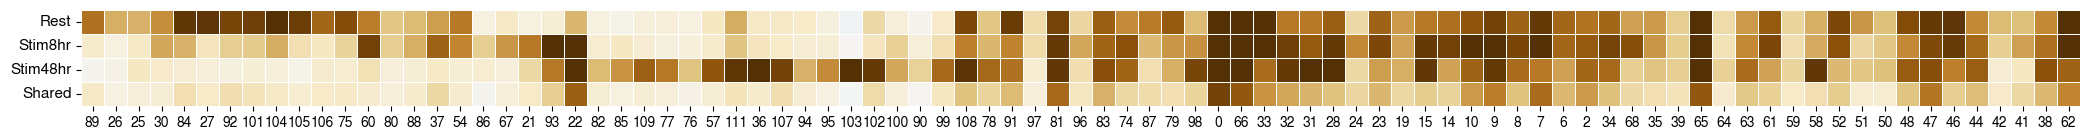

In [11]:
thres = 0.4
fig, ax = plt.subplots(figsize=(21, 1.5))
cmap = sns.color_palette("light:b", as_cmap=True)
sns.heatmap(cluster_df_filtered.loc[:,['corr_rest', 'corr_stim8hr', 'corr_stim48hr', 'corr_shared']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, 
            yticklabels=['Rest', 'Stim8hr', 'Stim48hr', 'Shared'])
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr', 'Shared'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_df_filtered.index.tolist(), fontsize=10, rotation=0)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/cluster_ngene>=4_corr>0.1_withlabel.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

### Selected cluster for the main figure

In [12]:
mask = ((cluster_df.cluster_gene_size>=55)&(cluster_df.corr_max>0.2))|\
((cluster_df.cluster_gene_size<55)&(cluster_df.cluster_gene_size>6)&(cluster_df.corr_max>0.3))|\
((cluster_df.cluster_gene_size==4)&(cluster_df.corr_max>0.375))|\
((cluster_df.cluster_gene_size==6)&(cluster_df.corr_max>0.32))
cluster_df_selected = cluster_df[mask].copy()
cluster_df_selected = cluster_df_selected.sort_index()

In [13]:
cluster_order = [106, 27, 105, 101, 84, 104, 30, 60,
                 21, 22, 99, 93, 
                 103, 36, 77, 107, 102, 111,
                 7, 62,
                 98, 46, 91, 33, 108, 61, 31, 32, 15, 28, 58,
                 68, 48, 74, 38,
                 34, 8, 2, 83, 9, 10, 0, 65, 66, 81]

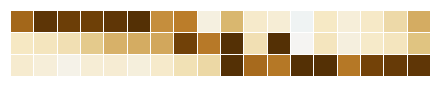

In [16]:
thres = 0.4
fig, ax = plt.subplots(figsize=(4.5, 0.96))
sns.heatmap(cluster_df_selected.loc[cluster_order[:18], ['corr_rest', 'corr_stim8hr', 'corr_stim48hr']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, yticklabels=False, xticklabels=False)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/selected_cluster_nolabel_condspec_withoutshared.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

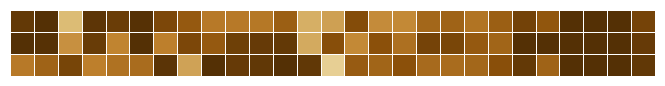

In [17]:
thres = 0.4
fig, ax = plt.subplots(figsize=(6.75, 0.96))
sns.heatmap(cluster_df_selected.loc[cluster_order[18:], ['corr_rest', 'corr_stim8hr', 'corr_stim48hr']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, yticklabels=False, xticklabels=False)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/selected_cluster_nolabel_condacross_withoutshared.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

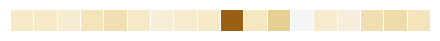

In [22]:
thres = 0.4
fig, ax = plt.subplots(figsize=(4.5, 0.52))
sns.heatmap(cluster_df_selected.loc[cluster_order[:18], ['corr_shared']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, yticklabels=False, xticklabels=False)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/selected_cluster_nolabel_condspec_shared.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

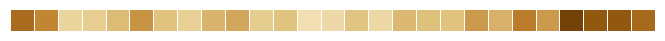

In [23]:
thres = 0.4
fig, ax = plt.subplots(figsize=(6.75, 0.52))
sns.heatmap(cluster_df_selected.loc[cluster_order[18:], ['corr_shared']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, yticklabels=False, xticklabels=False)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/selected_cluster_nolabel_condacross_shared.pdf', dpi=600, bbox_inches='tight', pad_inches=0)